In [167]:
from matplotlib import rcParams
rcParams['text.usetex'] = True
rcParams['font.family'] = 'serif'
rcParams['font.serif'] = ['Computer Modern'] 

In [168]:
import numpy as np


##################################################################################################################### SIMULACIÓN

L = 50 # Spatial domain size
N = 10000 # Number of spatial points
dx = L / N  # Spatial step size
print("dx = ", dx)
xi = np.linspace(-L / 2, L / 2, N)  # Spatial grid
dt = 0.0001 # Time step size
print("dt = ", dt)

##################################################################################################################### FUNCIÓN DE ONDA INICIAL

xi0 = 3 # Initial position of the wave packet
kappa_0 = 20 # Initial momentum of the wave packet
psi0 = (2 / np.pi)**(1/4) * np.exp(-(xi - xi0)**2) * np.exp(1j * kappa_0 * xi) # Initial wave function
psi0_star = (2 / np.pi)**(1/4) * np.exp(-(xi - xi0)**2) * np.exp(-1j * kappa_0 * xi) # Complex conjugate of the initial wave function


##################################################################################################################### POTENCIAL
alpha_param = 10 # Smoothness parameter of the potential
v_0 = 2 # Height of the potential 
b = 7.5 # FWHM of the potential
v = v_0 * (1 - 1 / (1 + np.abs((xi) / b)**alpha_param)) # Potential function 
##################################################################################################################### RANGO DE PROYECCIÓN

# Projection range
kmax = 1000
kmin = 0

dx =  0.005
dt =  0.0001


In [169]:
from scipy.integrate import trapezoid

def perform_momentum_measurement(psi, xi, N, kmax, kmin):
    dx = xi[1] - xi[0]  
    a = kmin
    b = kmax

    # Fourier transform to find momentum space representation
    psi_k = np.fft.fft(psi) * dx  
    k_values = np.fft.fftfreq(N, d=dx)*2*np.pi

    # Heaviside function to select the range of k values
    positive_k_indices = (k_values > a) & (k_values < b)
    psi_k_positive = psi_k[positive_k_indices]
    
    # Reconstruct the full wave function in momentum space
    psi_k_full = np.zeros(N, dtype=complex)
    psi_k_full[positive_k_indices] = psi_k_positive

    # Inverse Fourier transform to get back to position space
    psi_measured = np.fft.ifft(psi_k_full) # TF inversa

    # Normalization
    normalization_factor = np.sqrt(trapezoid(np.abs(psi_measured)**2, xi))
    psi_measured /= normalization_factor

    return psi_measured

##### Crank-Nicolson Scheme Matrices
$$
\begin{array}{cc}
\hat{A} = 
\begin{pmatrix}
1 + \alpha + \beta v(\xi) & -\alpha/2 & 0 & 0 & \cdots \\
-\alpha/2 & 1 + \alpha + \beta v(\xi) & -\alpha/2 & 0 & \cdots \\
0 & -\alpha/2 & 1 + \alpha + \beta v(\xi) & -\alpha/2 & \cdots \\
0 & 0 & -\alpha/2 & 1 + \alpha + \beta v(\xi) & \cdots \\
\vdots & \vdots & \vdots & \vdots & \ddots
\end{pmatrix}
&
\alpha = \dfrac{i\Delta\tau}{\kappa_0\left(\Delta\xi\right)^2} \\[40pt]
\hat{B} = 
\begin{pmatrix}
1 - \alpha - \beta v(\xi) & \alpha/2 & 0 & 0 & \cdots \\
\alpha/2 & 1 - \alpha - \beta v(\xi) & \alpha/2 & 0 & \cdots \\
0 & \alpha/2 & 1 - \alpha - \beta v(\xi) & \alpha/2 & \cdots \\
0 & 0 & \alpha/2 & 1 - \alpha - \beta v(\xi) & \cdots \\
\vdots & \vdots & \vdots & \vdots & \ddots
\end{pmatrix}
&
\beta = \dfrac{i\Delta\tau\kappa_0}{2}
\end{array}
$$

In [170]:
from scipy.sparse import diags

alpha = 1j * dt / (kappa_0 * dx**2)  
beta = 1j * dt * kappa_0 / 2  

diagonal_a = (1 + alpha + beta * v) * np.ones(N)
off_diagonal = -(alpha / 2) * np.ones(N - 1)
A = diags([off_diagonal, diagonal_a, off_diagonal], [-1, 0, 1], format="csr")

diagonal_b = (1 - alpha - beta * v) * np.ones(N)
B = diags([-off_diagonal, diagonal_b, -off_diagonal], [-1, 0, 1], format="csr")

diagonal_c = (1 + alpha) * np.ones(N)
off_diagonalx = -(alpha / 2) * np.ones(N - 1)
C = diags([off_diagonal, diagonal_c, off_diagonal], [-1, 0, 1], format="csr")

diagonal_d = (1 - alpha) * np.ones(N)
D = diags([-off_diagonalx, diagonal_d, -off_diagonalx], [-1, 0, 1], format="csr")

# C, D are matrices that solve an auxiliar wave packet used to compare the results

C = A
D = B


In [171]:
# calculates probability of finding the wave packet in the k range of interest

def calculate_positive_kappa_probability(psi, xi, kmax , kmin):

    k = np.fft.fftfreq(len(xi), d=xi[1] - xi[0]) * 2 * np.pi

    psi_k = np.fft.fft(psi) * (xi[1] - xi[0])  
       
    positive_k_mask = (k > kmin) & (k < kmax )
    
    prob_positive_k = np.sum(np.abs(psi_k[positive_k_mask])**2)
    
    total_prob = np.sum(np.abs(psi_k)**2)
    
    return prob_positive_k / total_prob

In [172]:
def kinetic_energy(psi, xi):
    
    dx = xi[1] - xi[0]  
    
    d2psi_dx2 = np.gradient(np.gradient(psi, dx), dx)

    kinetic_energy = np.abs((1/kappa_0) * trapezoid(np.conjugate(psi) * d2psi_dx2, xi))
    
    return kinetic_energy

In [173]:
def potential_energy(psi, xi):

    potential_energy = np.abs((kappa_0) * trapezoid(np.conjugate(psi) * v * psi, xi))
    
    return potential_energy

In [174]:
def psi_mom(psi):
    
    psi_k = np.fft.fft(psi) * dx

    return psi_k

Starting animation with 200 frames, 225000 measurements
Waiting...
Waiting...
Waiting...
Waiting...


Frame: 3/200 (1.5%) - Time: 11.3s - Measurements: 950
Measurement #1000: t=0.1475, p=1.000000
Frame: 5/200 (2.5%) - Time: 19.8s - Measurements: 1900
Measurement #2000: t=0.2475, p=1.000000
Frame: 7/200 (3.5%) - Time: 27.8s - Measurements: 2850
Measurement #3000: t=0.3475, p=1.000000
Frame: 9/200 (4.5%) - Time: 36.4s - Measurements: 3800
Measurement #4000: t=0.4475, p=1.000000
Frame: 11/200 (5.5%) - Time: 44.5s - Measurements: 4750
Measurement #5000: t=0.5475, p=1.000000
Frame: 13/200 (6.5%) - Time: 52.8s - Measurements: 5700
Measurement #6000: t=0.6475, p=1.000000
Frame: 15/200 (7.5%) - Time: 60.9s - Measurements: 6650
Measurement #7000: t=0.7475, p=1.000000
Frame: 17/200 (8.5%) - Time: 74.9s - Measurements: 7600
Measurement #8000: t=0.8475, p=1.000000
Frame: 19/200 (9.5%) - Time: 86.6s - Measurements: 8550
Measurement #9000: t=0.9475, p=1.000000
Frame: 22/200 (11.0%) - Time: 99.7s - Measurements: 9975
Measurement #10000: t=1.0475, p=1.000000
Frame: 24/200 (12.0%) - Time: 107.8s - Meas

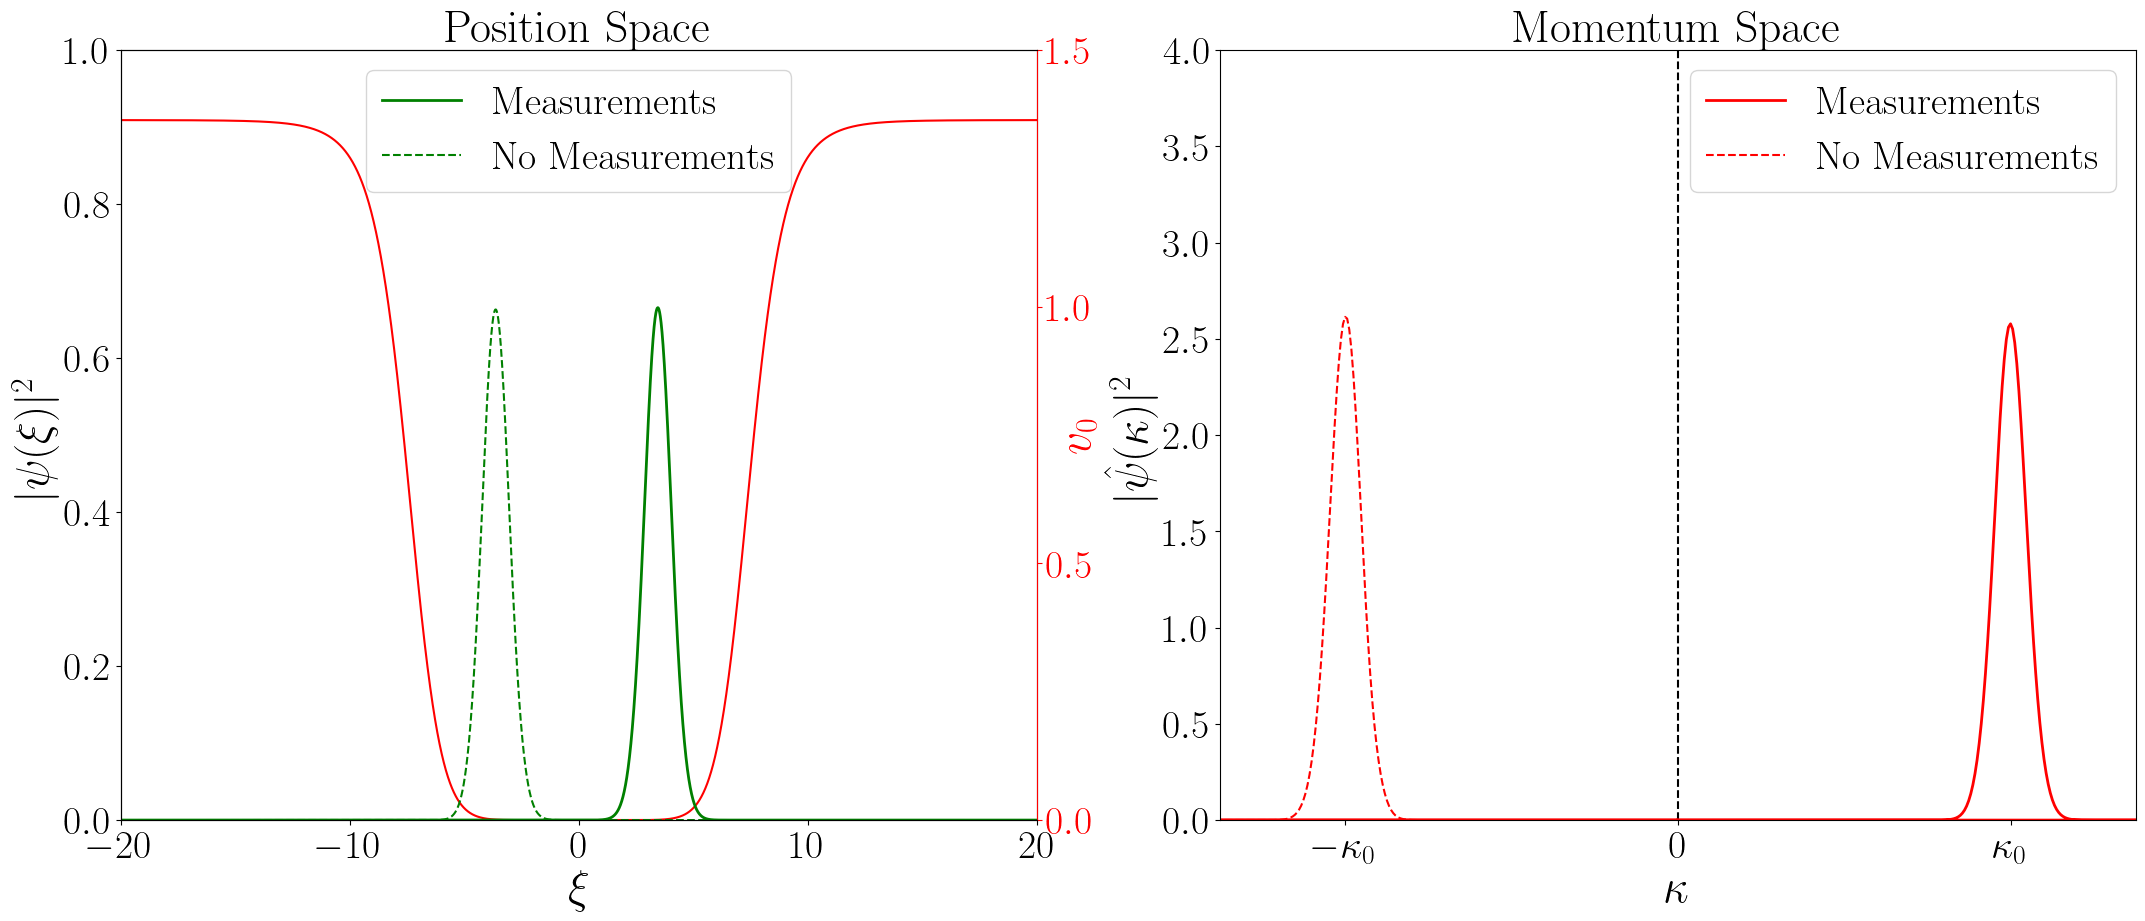

In [175]:
from matplotlib.animation import FuncAnimation 
from numpy.fft import fftshift
from matplotlib import pyplot as plt
from scipy.sparse.linalg import spsolve
import sys
import time

##################################################################################################################### PARÁMETROS ANIMACIÓN 

t_max = 9.5
t_steps = int((t_max) / dt)

num_frames = 200
steps_per_frame = t_steps // num_frames
 
##################################################################################################################### MEDICIONES

t_start = 0 # Starting measurement time
t_final = t_max # Final measurement time

num_measurements = 225000 

if num_measurements == 1:
    momentos_de_medicion = [t_max]  # One measurement at t_max
else:
    momentos_de_medicion = np.linspace(t_final / num_measurements+t_start, t_final, num_measurements)

indice_medicion = 0  # Fixed variable naming consistency

##################################################################################################################### INICIALIZANDO

psi = psi0.copy()
psiref = psi0.copy()
psi_evolution = []
psi_evolution_mom = []
probs = []
kinetic_energies = []
potential_energies = []
k = np.fft.fftfreq(N, d=dx)*2*np.pi
psi_k = psi_mom(psi)
psi_k1 = psi_mom(psiref)
psi_k_star = psi_mom(psi0_star)
p = 1

# Progress tracking variables
start_time = time.time()
measurement_count = 0

##################################################################################################################### CONTROL LAYOUT ANIMACIÓN

fig, (ax_pos, ax_mom) = plt.subplots(1, 2, figsize=(26, 10))

######### POSITION
ax_pos.set_ylim(0,1)  # EJE Y
ax_pos.set_xlim(-20,20) # EJE X

######### MOMENTUM
ax_mom.set_ylim(0,4)    # EJE Y
ax_mom.set_xlim(-kappa_0-7.5, kappa_0+7.5) # EJE X

##################################################################################################################### POTENCIAL
ax_pos.plot(xi, v*(1/2.2), color='r', linestyle='-',alpha=1)

##################################################################################################################### LINEAS DE REFERENCIA
ax_mom.axvline(x=kmin, color='k', linestyle='--', alpha=1)
ax_pos.set_title(rf'Position Space', fontsize=33)
ax_mom.set_title(f'Momentum Space', fontsize=33)

##################################################################################################################### LINEAS 
line_pos, = ax_pos.plot(xi, np.abs(psi)**2, color='green', alpha=1, linewidth=2)
line_mom, = ax_mom.plot(k, np.abs(psi_k)**2, color='red', alpha=1, linewidth=2, 
                        label=r"$|\hat{\psi}(\kappa)|$ with measurements")
line_pos1, = ax_pos.plot(xi, np.abs(psiref)**2, color='green', linestyle='--', alpha=1) 
line_mom1, = ax_mom.plot(k, np.abs(psi_k1)**2, color='red', linestyle='--', alpha=1)

##################################################################################################################### UPDATER

def update(frame):
    global psi, indice_medicion, p, psiref, psi_k, psi_evolution, kinetic_energies, potential_energies
    global psi_evolution_mom, measurement_count
    
    current_time = frame * steps_per_frame * dt  

    if frame == 0:
        sys.stdout.write("Waiting...\n")
        sys.stdout.flush()
        return line_pos, line_mom, line_pos1, line_mom1

    # Log progress
    progress = frame / num_frames * 100
    elapsed = time.time() - start_time
    sys.stdout.write(f"\rFrame: {frame}/{num_frames} ({progress:.1f}%) - Time: {elapsed:.1f}s - Measurements: {measurement_count}")
    sys.stdout.flush()

    # Store evolution data
    psi_evolution.append((current_time, np.abs(psi)**2))
    psi_evolution_mom.append((current_time, np.abs(fftshift(psi_k))**2))
    kinetic_energies.append((current_time, kinetic_energy(psi,xi)/p))
    potential_energies.append((current_time, potential_energy(psi,xi)/p))

    # Run simulation steps
    for _ in range(steps_per_frame):  
        psi = spsolve(A, B @ psi)
        psiref = spsolve(C, D @ psiref)
        current_time = current_time + dt 
    
        # Check for measurement
        if indice_medicion < len(momentos_de_medicion) and current_time >= momentos_de_medicion[indice_medicion]:
            old_p = p
            p = p * calculate_positive_kappa_probability(psi, xi, kmax, kmin)
            psi = (np.sqrt(p)) * perform_momentum_measurement(psi, xi, N, kmax, kmin)
            indice_medicion += 1
            measurement_count += 1
            
            # Only log every 1000 measurements to avoid console spam
            if measurement_count % 1000 == 0:
                sys.stdout.write(f"\nMeasurement #{measurement_count}: t={current_time:.4f}, p={p:.6f}\n")
                sys.stdout.flush()

    # Update the wave function visualization
    line_pos.set_ydata(np.abs(psi)**2)
    line_pos1.set_ydata(np.abs(psiref)**2)

    psi_k = psi_mom(psi)
    psi_k1 = psi_mom(psiref)
    line_mom.set_ydata(np.abs(psi_k)**2)
    line_mom1.set_ydata(np.abs(psi_k1)**2)
   
    return line_pos, line_mom, line_pos1, line_mom1

# Eje para la barrera
ax2 = ax_pos.twinx()  
ax2.set_ylim(0, 1.5)  # Límite = max barrera pot
ax2.set_ylabel(r'$v_0$',color='r',size=33, labelpad=-25)
ax2.tick_params(axis='y', colors='red')  
ax2.spines['right'].set_color('red') 

ax_pos.tick_params(axis='both', labelsize=28.5)
ax_mom.tick_params(axis='both', labelsize=28.5)
ax2.tick_params(axis='y', labelsize=28.5)
ax2.set_yticks([0, 0.5, 1, 1.5])

ax_pos.set_xlabel(r'$\xi$', fontsize=33)
ax_mom.set_xlabel(r'$\kappa$', fontsize=33)

ax_pos.set_ylabel(r'$|\psi(\xi)|^2$', size=33)
ax_mom.set_ylabel(r'$|\hat{\psi}(\kappa)|^2$', size=33)

ax_mom.set_xticks([-kappa_0, 0, kappa_0], [r"$-\kappa_0$", 0, r"$\kappa_0$"])

# add a legend for position space where we say green dashed line is absence of measurement and green line is with measurement
ax_pos.legend([line_pos, line_pos1], [r"Measurements", r"No Measurements"], loc='upper center', fontsize=28.5)
# add a legend for momentum space where we say red dashed line is absence of measurement and red line is with measurement
ax_mom.legend([line_mom, line_mom1], [r"Measurements", r"No Measurements"], loc='upper right', fontsize=28.5)





##################################################################################################################### ANIMACIÓN

print(f"Starting animation with {num_frames} frames, {num_measurements} measurements")
ani = FuncAnimation(fig, update, frames=num_frames, blit=True)
ani.save('transloc_1.mp4', writer='ffmpeg', fps=60)
print("\nAnimation complete!")

In [176]:
# Convertir the tuple list psi_evolution to a numpy array
density_matrix = np.array([density_t for _, density_t in psi_evolution]).T

# Extract the times from the list of tuples
times = [t for t, _ in psi_evolution]  # Extraer los tiempos de la lista de tuplas

T = []
V = []
times = []
centros = []

for i in range (len(kinetic_energies)):
    T.append(kinetic_energies [i][1])
    times.append(kinetic_energies[i][0])

for i in range (len(potential_energies)):
    V.append(potential_energies [i][1])

for i in range (len(psi_evolution)):
    psi2 = np.abs(psi_evolution[i][1])**2
    centros.append (np.sum(xi * psi2) / np.sum(psi2))

positions= xi

density_matrix_mom = np.array([density_t for _, density_t in psi_evolution_mom]).T
times_mom = [t for t, _ in psi_evolution_mom]  
k= np.fft.fftfreq(N, d=dx)*2*np.pi
k  = fftshift(k)


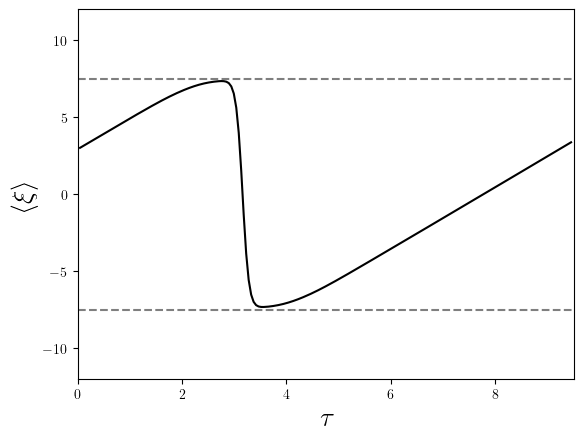

In [177]:
plt.plot(times, centros, color='k')
plt.axhline(y=-7.5, color='k', linestyle='--', alpha = 0.5)
plt.axhline(y=7.5, color='k', linestyle='--', alpha = 0.5)
plt.xlabel(r'$\tau$', fontsize = 20)
plt.ylabel(r'$\left\langle\xi\right\rangle$', fontsize = 20)
plt.xlim(0,t_max)
plt.ylim(-12,12)
# plt.legend()
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

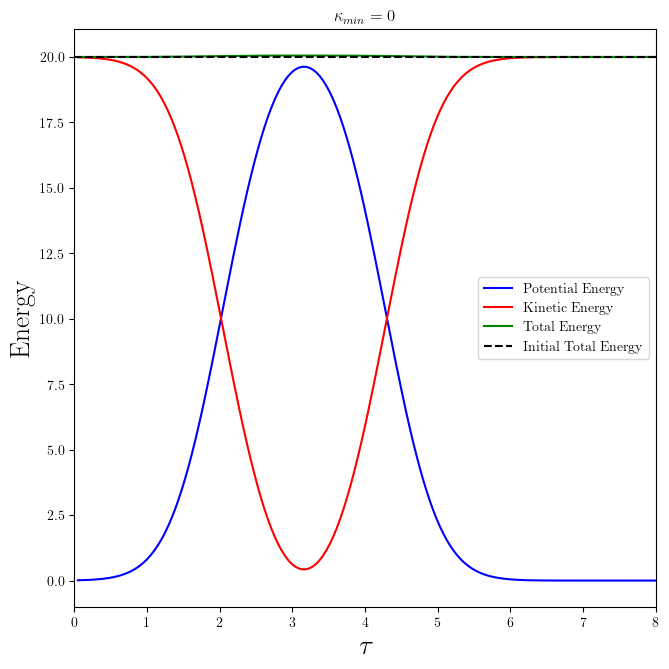

In [178]:
T = np.array (T)
V = np.array (V)


plt.figure(figsize=(7.5,7.5))
plt.title(r'$\kappa_{min} = 0$')
plt.plot(times, V, label='Potential Energy', color='blue')
plt.plot(times, T, label='Kinetic Energy', color='red')
plt.plot(times, T+V, label='Total Energy', color='green')
plt.axhline(y=T[0]+V[0], color='k', linestyle='--', label= 'Initial Total Energy') 
plt.xlabel(r'$\tau$', fontsize = 20)
plt.ylabel('Energy', fontsize = 20)
plt.xlim(0,8)
plt.legend()
plt.show